**1.데이터셋**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

movies_df=pd.read_csv("/content/drive/MyDrive/ailab1/movies.csv")
ratings_df=pd.read_csv("/content/drive/MyDrive/ailab1/ratings.csv")

**2.시청순서 시퀀스**

In [ ]:
# movieId 매핑 딕셔너리
id_mapping = {
    144606: 6003,
    26958: 838,
    147002: 32600,
    168358: 2851,
    64997: 34048
}

# ratings 데이터프레임에 매핑 적용
ratings_df['movieId'] = ratings_df['movieId'].replace(id_mapping)

# ratings와 movies를 병합
merged_df = ratings_df.merge(movies_df, on='movieId', how='left')

# 결과 확인
print(merged_df.head())

unique_titles_count = merged_df['title'].nunique()
print(f"Unique titles count: {unique_titles_count}")

merged_df = merged_df.sort_values(by=['userId', 'timestamp'])


user_movie_sequences = merged_df.groupby('userId')['title'].apply(list)


print("Sample User Movie Sequence:")
print(user_movie_sequences)

   userId  movieId  rating  timestamp                        title  \
0       1        1     4.0  964982703             Toy Story (1995)   
1       1        3     4.0  964981247      Grumpier Old Men (1995)   
2       1        6     4.0  964982224                  Heat (1995)   
3       1       47     5.0  964983815  Seven (a.k.a. Se7en) (1995)   
4       1       50     5.0  964982931   Usual Suspects, The (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                               Comedy|Romance  
2                        Action|Crime|Thriller  
3                             Mystery|Thriller  
4                       Crime|Mystery|Thriller  
Unique titles count: 9719
Sample User Movie Sequence:
userId
1      [She's the One (1996), Star Wars: Episode VI -...
2      [Shawshank Redemption, The (1994), Inception (...
3      [Highlander (1986), Tron (1982), Star Trek: Th...
4      [Jeffrey (1995), Breakfast at Tiffany's (1961)

**2.1 제목 전처리**

In [ ]:
#제목 전처리

def preprocess_movie_title(title):
    """
    Preprocess movie titles by:
    - Removing spaces and special characters
    - Converting to lowercase
    - Replacing spaces with underscores for consistency
    """
    return title.strip().replace(' ', '_').replace('(', '').replace(')', '').replace("'", '').lower()

# 각 userId의 시청 시퀀스에 전처리 적용
user_movie_sequences_preprocessed = user_movie_sequences.apply(
    lambda titles: [preprocess_movie_title(title) for title in titles]
)

# 전처리된 결과 확인
print(user_movie_sequences_preprocessed.head())
print(type(user_movie_sequences_preprocessed))

userId
1    [shes_the_one_1996, star_wars:_episode_vi_-_re...
2    [shawshank_redemption,_the_1994, inception_201...
3    [highlander_1986, tron_1982, star_trek:_the_mo...
4    [jeffrey_1995, breakfast_at_tiffanys_1961, bar...
5    [dances_with_wolves_1990, batman_1989, apollo_...
Name: title, dtype: object
<class 'pandas.core.series.Series'>


In [ ]:
from sklearn.model_selection import train_test_split

# 각 유저의 시퀀스에서 80%를 훈련 데이터로 분리
train_data = []

for seq in user_movie_sequences_preprocessed:
    split_index = int(len(seq) * 0.8)  # 시퀀스의 80%를 계산
    train_data.append(seq[:split_index])

In [ ]:
!pip install gensim
from gensim.models import Word2Vec

**3.스킵그램 임베딩**

In [ ]:


# Series를 리스트로 변환
sentences = user_movie_sequences_preprocessed.tolist()

from gensim.models import Word2Vec

# 윈도우 크기 리스트 정의
window_sizes = [3, 5, 7, 9, 11, 13, 15]  # 원하는 윈도우 크기들

# 결과 저장 딕셔너리
results = {}

# 모든 윈도우 크기에 대해 Word2Vec 모델 학습 및 유사 영화 저장
for window in window_sizes:
    print(f"Training Word2Vec model with window size: {window}")

    # Word2Vec 모델 학습
    model = Word2Vec(
        sentences=sentences,  # 영화 시퀀스 데이터
        vector_size=100,                # 임베딩 차원 수
        window=window,                  # 윈도우 크기
        min_count=1,                    # 최소 등장 횟수
        sg=1                            # Skip-gram 설정
    )
    # 모든 영화에 대해 유사한 10개 영화 추출
    similar_movies_for_window = {}

    for movie in model.wv.index_to_key:  # 학습된 모든 영화에 대해
        similar_movies_for_window[movie] = model.wv.most_similar(movie, topn=10)

    # 결과 저장
    results[window] = similar_movies_for_window

    # CSV로 저장
    df = pd.DataFrame({
        'movie': list(similar_movies_for_window.keys()),
        'similar_movies': [', '.join([f"{sim[0]}({sim[1]:.2f})" for sim in sims])
                           for sims in similar_movies_for_window.values()]
           })
    df.to_csv(f'similar_movies_window_{window}.csv', index=False)
    print(f"Results saved for window size {window}.")

print("All window size results have been saved.")

Training Word2Vec model with window size: 3
Results saved for window size 3.
Training Word2Vec model with window size: 5
Results saved for window size 5.
Training Word2Vec model with window size: 7
Results saved for window size 7.
Training Word2Vec model with window size: 9
Results saved for window size 9.
Training Word2Vec model with window size: 11
Results saved for window size 11.
Training Word2Vec model with window size: 13
Results saved for window size 13.
Training Word2Vec model with window size: 15
Results saved for window size 15.
All window size results have been saved.


**4.기본 CF와 성능비교**

**4.1 Rsme, Precision,Recall**


사용자가 실제로 4.0 이상으로 평가한 영화 리스트를 생성->추천 영화

스킵그램으로 계산한 예측 평점 중 4.0 이상인 영화 리스트를 생성.
Precision:

추천 영화 리스트에서 얼마나 많은 영화가 Ground Truth에 포함되었는가?
Recall:

Ground Truth에서 얼마나 많은 영화가 추천 영화 리스트에 포함되었는가

In [ ]:
merged_df['processed_title'] = merged_df['title'].apply(preprocess_movie_title)

# 결과 확인
print("Merged DataFrame with Processed Titles (Sample):")
print(merged_df[['userId', 'processed_title', 'rating']].head())

Merged DataFrame with Processed Titles (Sample):
     userId                                  processed_title  rating
43        1                                shes_the_one_1996     4.0
73        1  star_wars:_episode_vi_-_return_of_the_jedi_1983     5.0
120       1                                       bambi_1942     5.0
171       1   star_wars:_episode_i_-_the_phantom_menace_1999     4.0
183       1                           13th_warrior,_the_1999     4.0


In [ ]:
train_ratings, test_ratings = train_test_split(merged_df, test_size=0.2, random_state=42)

In [ ]:
# 중복 데이터 처리: 평균 평점을 계산
train_ratings = train_ratings.groupby(['userId', 'processed_title'], as_index=False)['rating'].mean()
test_ratings = test_ratings.groupby(['userId', 'processed_title'], as_index=False)['rating'].mean()


In [ ]:
# 중복된 userId와 processed_title 확인
duplicates = train_ratings[train_ratings.duplicated(subset=['userId', 'processed_title'], keep=False)]
print("Duplicates in train_ratings (Sample):")
print(duplicates)


Duplicates in train_ratings (Sample):
Empty DataFrame
Columns: [userId, processed_title, rating]
Index: []


In [ ]:
# 중복 처리 후 사용자-아이템 매트릭스 생성
train_user_item_matrix = train_ratings.pivot(index='userId', columns='processed_title', values='rating')
test_user_item_matrix = test_ratings.pivot(index='userId', columns='processed_title', values='rating')

# 결과 확인
print("Train User-Item Matrix (Sample):")
print(train_user_item_matrix.head())

print("\nTest User-Item Matrix (Sample):")
print(test_user_item_matrix.head())


Train User-Item Matrix (Sample):
processed_title  *batteries_not_included_1987  ...all_the_marbles_1981  \
userId                                                                   
1                                         NaN                      NaN   
2                                         NaN                      NaN   
3                                         NaN                      NaN   
4                                         NaN                      NaN   
5                                         NaN                      NaN   

processed_title  ...and_justice_for_all_1979  \
userId                                         
1                                        NaN   
2                                        NaN   
3                                        NaN   
4                                        NaN   
5                                        NaN   

processed_title  00_schneider_-_jagd_auf_nihil_baxter_1994  1-900_06_1994  \
userId                            

In [ ]:
# Skip-gram 결과 데이터 읽기
similar_movies_df = pd.read_csv('/content/similar_movies_window_15.csv')

# 유사 영화 딕셔너리 생성
similar_movies = {}
for _, row in similar_movies_df.iterrows():
    movie_title = row['movie']
    similar_movies_list = [
        (sim.split('(')[0], float(sim.split('(')[1][:-1]))
        for sim in row['similar_movies'].split(', ')
    ]
    similar_movies[movie_title] = similar_movies_list

# 결과 확인
print("Processed Similar Movies Data (Sample):")
print(list(similar_movies.items())[:5])


Processed Similar Movies Data (Sample):
[('forrest_gump_1994', [('silence_of_the_lambs,_the_1991', 0.93), ('braveheart_1995', 0.9), ('shawshank_redemption,_the_1994', 0.9), ('fugitive,_the_1993', 0.88), ('while_you_were_sleeping_1995', 0.88), ('bad_education_la_mala_educación_2004', 0.88), ('thesis_tesis_1996', 0.88), ('apollo_13_1995', 0.87), ('cloak_&_dagger_1984', 0.87), ('crimson_tide_1995', 0.87)]), ('shawshank_redemption,_the_1994', [('silence_of_the_lambs,_the_1991', 0.95), ('forrest_gump_1994', 0.9), ('pulp_fiction_1994', 0.88), ('braveheart_1995', 0.88), ('usual_suspects,_the_1995', 0.87), ('schindlers_list_1993', 0.85), ('saving_private_ryan_1998', 0.85), ('pirates_of_silicon_valley_1999', 0.85), ('kickin_it_old_skool_2007', 0.84), ('fight_club_1999', 0.84)]), ('pulp_fiction_1994', [('apollo_13_1995', 0.91), ('silence_of_the_lambs,_the_1991', 0.9), ('shawshank_redemption,_the_1994', 0.88), ('forrest_gump_1994', 0.86), ('dances_with_wolves_1990', 0.86), ('american_beauty_1999'

In [ ]:
# ground_truth_df를 test_ratings에서 정의
ground_truth_df = test_ratings.copy()  # 또는 적합한 데이터프레임 사용


In [ ]:
def calculate_predicted_rating(user_id, movie_title, user_item_matrix, similar_movies, k=10):
    """
    유사 영화 기반으로 평점을 예측
    """
    if movie_title not in similar_movies:
        return np.nan  # 유사 영화가 없는 경우

    # 상위 K개의 유사 영화 가져오기
    similar_items = similar_movies[movie_title][:k]
    weighted_ratings = []
    similarity_sum = 0

    for similar_title, similarity in similar_items:
        # 유사 영화가 사용자-아이템 매트릭스에 존재하는지 확인
        if similar_title in user_item_matrix.columns:
            if user_id in user_item_matrix.index:
                # 유저가 해당 유사 영화에 평점을 남겼는지 확인
                rating = user_item_matrix.at[user_id, similar_title]
                if not pd.isna(rating):  # 평점이 있는 경우
                    weighted_ratings.append(similarity * rating)
                    similarity_sum += similarity

    # 가중합을 계산하여 반환
    return np.sum(weighted_ratings) / similarity_sum if similarity_sum > 0 else np.nan


In [ ]:
predicted_ratings = []

for _, row in ground_truth_df.iterrows():
    user_id = row['userId']
    movie_title = row['processed_title']
    true_rating = row['rating']

    # 예측 평점 계산
    predicted_rating = calculate_predicted_rating(
        user_id=user_id,
        movie_title=movie_title,
        user_item_matrix=train_user_item_matrix,  # 사용자-아이템 매트릭스
        similar_movies=similar_movies,  # 전처리된 유사 영화 데이터
        k=10  # 상위 10개 유사 영화 사용
    )
    predicted_ratings.append((user_id, movie_title, true_rating, predicted_rating))

# DataFrame으로 변환
predicted_ratings_df = pd.DataFrame(predicted_ratings, columns=['userId', 'movie_title', 'ground_truth', 'predicted_rating'])


In [ ]:
print("Predicted Ratings (Sample):")
print(predicted_ratings_df.head())

Predicted Ratings (Sample):
   userId             movie_title  ground_truth  predicted_rating
0       1  american_tail,_an_1986           5.0          3.332180
1       1             batman_1989           4.0          4.322695
2       1      bottle_rocket_1996           5.0          4.000000
3       1     canadian_bacon_1995           5.0               NaN
4       1   dirty_dozen,_the_1967           5.0          4.000000


In [ ]:
# RMSE 계산
squared_errors = [
    (true_rating - predicted_rating) ** 2
    for _, _, true_rating, predicted_rating in predicted_ratings
    if not pd.isna(predicted_rating)
]

rmse = np.sqrt(np.mean(squared_errors)) if squared_errors else float('nan')
print(f"RMSE: {rmse:.4f}")


RMSE: 0.9451


In [ ]:
def evaluate_precision_recall(predicted_ratings_df, ground_truth_df, threshold=4.0):
    """
    Precision과 Recall 계산 함수.
    """
    precision_scores = []
    recall_scores = []

    # 각 사용자에 대해 계산
    for user_id in ground_truth_df['userId'].unique():
        # Ground Truth: 실제로 좋아한 영화 (평점 >= threshold)
        user_ground_truth = ground_truth_df[ground_truth_df['userId'] == user_id]
        relevant_movies = set(
            user_ground_truth[user_ground_truth['rating'] >= threshold]['processed_title']
        )

        # 예측된 추천 영화 (평점 >= threshold)
        user_predictions = predicted_ratings_df[predicted_ratings_df['userId'] == user_id]
        recommended_movies = set(
            user_predictions[user_predictions['predicted_rating'] >= threshold]['movie_title']
        )

        # True Positives
        true_positives = relevant_movies & recommended_movies

        # Precision
        precision = len(true_positives) / len(recommended_movies) if len(recommended_movies) > 0 else 0

        # Recall
        recall = len(true_positives) / len(relevant_movies) if len(relevant_movies) > 0 else 0

        precision_scores.append(precision)
        recall_scores.append(recall)

    # 평균 Precision과 Recall 계산
    avg_precision = sum(precision_scores) / len(precision_scores)
    avg_recall = sum(recall_scores) / len(recall_scores)

    return avg_precision, avg_recall


In [ ]:
# Precision과 Recall 계산
precision, recall = evaluate_precision_recall(predicted_ratings_df, ground_truth_df, threshold=4.0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Precision: 0.6100
Recall: 0.3502


In [ ]:
Precision과 Recall 계산 방식 요약
Ground Truth:

사용자가 실제로 4.0 이상으로 평가한 영화 리스트를 생성.
추천 영화:

스킵그램으로 계산한 예측 평점 중 4.0 이상인 영화 리스트를 생성.
Precision:

추천 영화 리스트에서 얼마나 많은 영화가 Ground Truth에 포함되었는가?
Recall:

Ground Truth에서 얼마나 많은 영화가 추천 영화 리스트에 포함되었는가?

In [ ]:
import os
import pandas as pd
from gensim.models import Word2Vec

# 영화 시퀀스를 리스트로 변환
sentences = user_movie_sequences_preprocessed.tolist()

# 저장 디렉토리 설정
save_directory = "./"  # 결과 저장 경로
os.makedirs(save_directory, exist_ok=True)

# Word2Vec 모델 학습 (윈도우 크기 5 기준)
print("Training Word2Vec model with window size: 15")

model = Word2Vec(
    sentences=sentences,  # 영화 시퀀스 데이터
    vector_size=100,      # 임베딩 차원 수
    window=5,             # 윈도우 크기
    min_count=1,          # 최소 등장 횟수
    sg=1                  # Skip-gram 설정
)

# 모든 영화에 대해 유사한 10개 영화 추출
similar_movies_for_window = {}
for movie in model.wv.index_to_key:  # 학습된 모든 영화에 대해
    similar_movies_for_window[movie] = model.wv.most_similar(movie, topn=10)

# CSV로 저장
df = pd.DataFrame({
    'movie': list(similar_movies_for_window.keys()),
    'similar_movies': [', '.join([f"{sim[0]}({sim[1]:.2f})" for sim in sims])
                       for sims in similar_movies_for_window.values()]
})
csv_path = os.path.join(save_directory, 'similar_movies_window_15.csv')
df.to_csv(csv_path, index=False)
print(f"Results saved for window size 15 at {csv_path}.")

# Word2Vec 모델 저장
model_path = os.path.join(save_directory, 'word2vec_model_window_15.model')
model.save(model_path)
print(f"Word2Vec model saved at {model_path}.")


Training Word2Vec model with window size: 15
Results saved for window size 15 at ./similar_movies_window_15.csv.
Word2Vec model saved at ./word2vec_model_window_15.model.


In [ ]:

# 저장된 모델 로드
model_path = '/content/word2vec_model_window_15.model'
model = Word2Vec.load(model_path)
print(f"Model loaded from {model_path}.")

# 영화 제목과 벡터 추출
movie_titles = list(model.wv.index_to_key)  # 학습된 영화 제목 리스트
movie_vectors = np.array([model.wv[title] for title in movie_titles])  # 영화 임베딩 벡터

print(f"Number of movies: {len(movie_titles)}")


Model loaded from /content/word2vec_model_window_15.model.
Number of movies: 9719


**4.2 t-SNE 시각화**

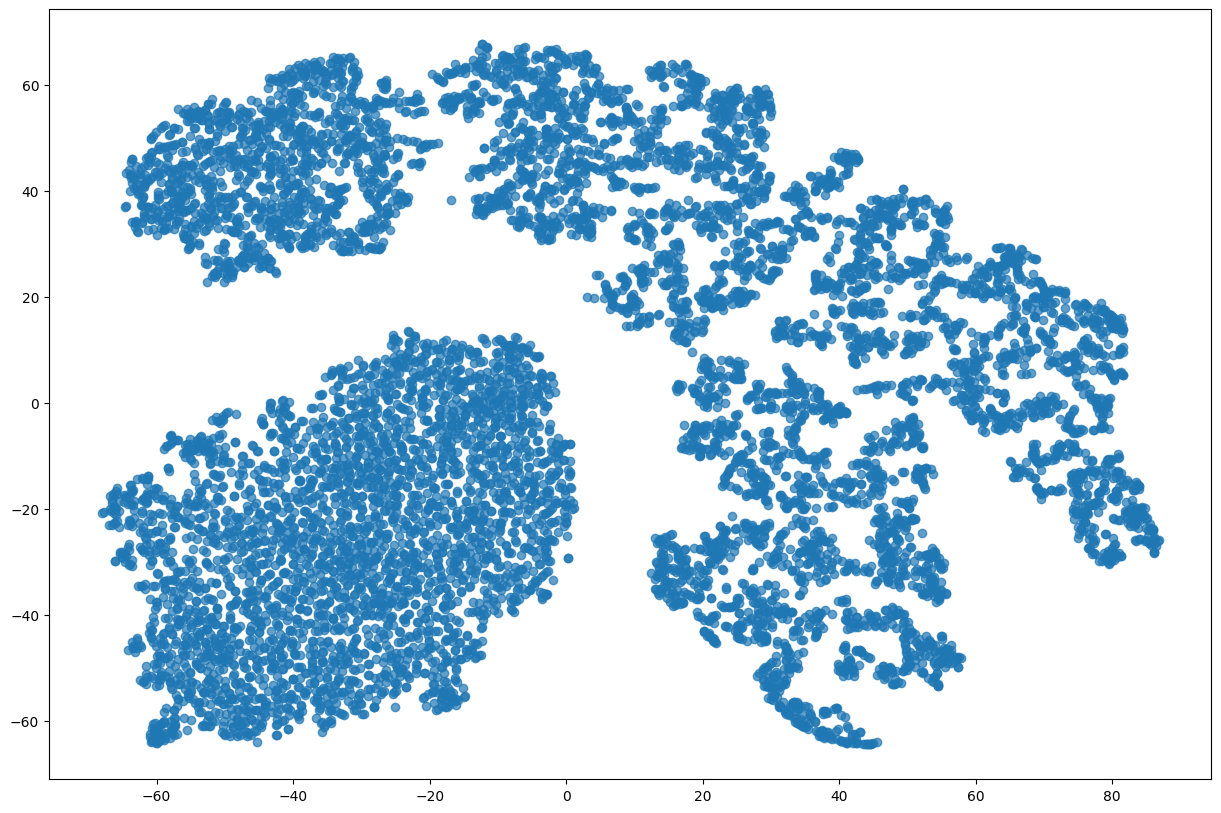

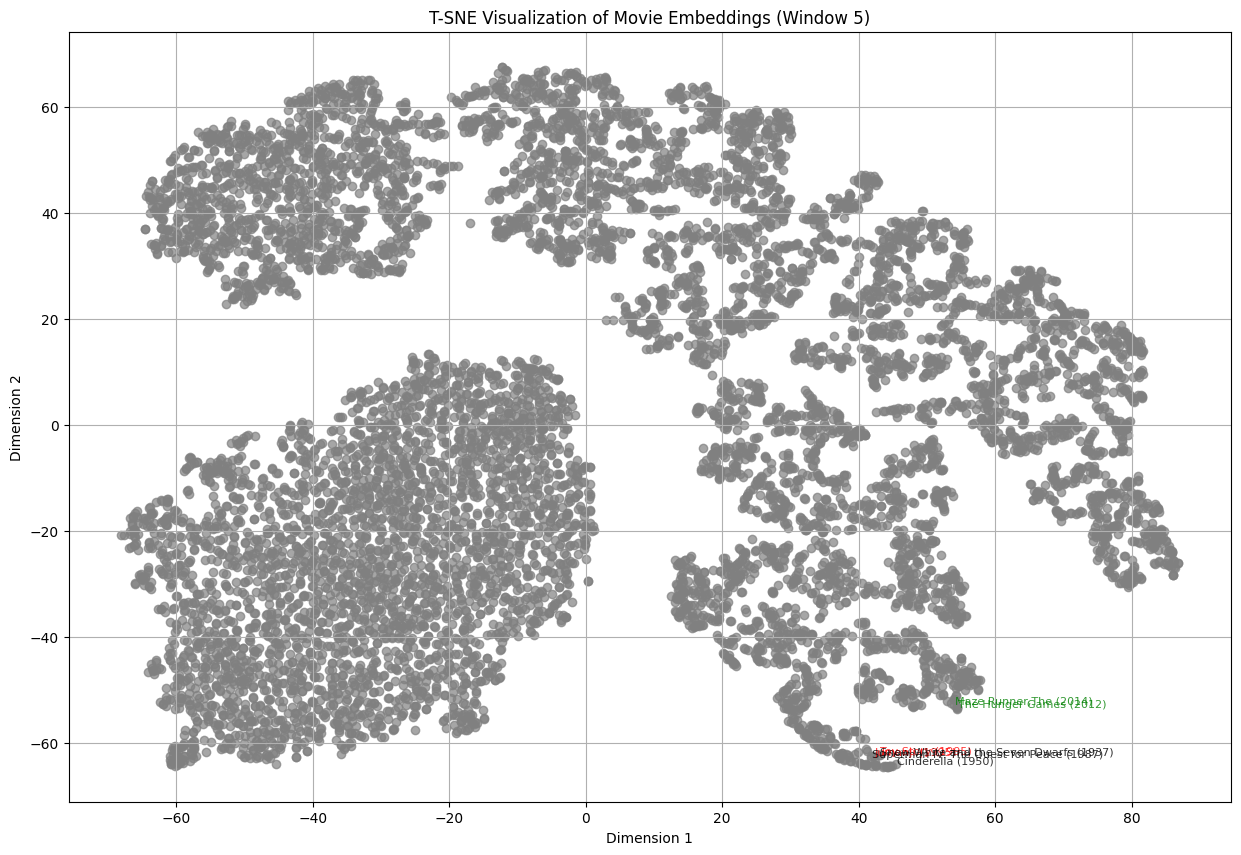

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# T-SNE 차원 축소
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced_vectors = tsne.fit_transform(movie_vectors)

# 시각화
plt.figure(figsize=(15, 10))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], alpha=0.7)

movie_titles = [
    ("Jumanji (1995)","red"),
    ("Toy Story (1995)","red"),
    ("Cinderella (1950)","black"),
    ("Snow White and the Seven Dwarfs (1937)","black"),
    ("Maze Runner,The (2014)","green"),
    ("The Hunger Games (2012)","green"),
    ("Superman IV: The Quest for Peace (1987)","black"),
    # 여기에 추가적으로 영화 제목 입력
]
# 시각화
plt.figure(figsize=(15, 10))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], alpha=0.7, color="gray")  # 기본 점은 회색으로 표시

# 영화 제목 텍스트와 색상 지정
for i, (title, color) in enumerate(movie_titles):
    plt.text(reduced_vectors[i, 0] + 0.1, reduced_vectors[i, 1] + 0.1, title, fontsize=8, color=color, alpha=0.8)

plt.title("T-SNE Visualization of Movie Embeddings (Window 5)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# 저장된 윈도우별 결과 파일과 윈도우 크기 리스트 정의
window_sizes = [3, 5, 7, 9, 11, 13, 15]
base_path = "/content"  # 저장된 CSV 파일 경로
results = []

# 모든 윈도우 크기에 대해 반복 처리
for window in window_sizes:
    print(f"Processing for window size {window}...")

    # CSV 파일 로드
    file_path = f"{base_path}/similar_movies_window_{window}.csv"
    similar_movies_df = pd.read_csv(file_path)

    # 유사 영화 딕셔너리 생성
    similar_movies = {}
    for _, row in similar_movies_df.iterrows():
        movie_title = row['movie']
        similar_movies_list = [
            (sim.split('(')[0], float(sim.split('(')[1][:-1]))
            for sim in row['similar_movies'].split(', ')
        ]
        similar_movies[movie_title] = similar_movies_list

    # 예측 평점 생성
    predicted_ratings = []
    for _, row in ground_truth_df.iterrows():
        user_id = row['userId']
        movie_title = row['processed_title']
        true_rating = row['rating']

        # 예측 평점 계산
        predicted_rating = calculate_predicted_rating(
            user_id=user_id,
            movie_title=movie_title,
            user_item_matrix=train_user_item_matrix,  # 사용자-아이템 매트릭스
            similar_movies=similar_movies,           # 유사 영화 데이터
            k=10                                     # 상위 10개 유사 영화 사용
        )
        predicted_ratings.append((user_id, movie_title, true_rating, predicted_rating))

    # DataFrame 변환
    predicted_ratings_df = pd.DataFrame(predicted_ratings, columns=['userId', 'movie_title', 'ground_truth', 'predicted_rating'])

    # RMSE 계산
    squared_errors = [
        (true_rating - predicted_rating) ** 2
        for _, _, true_rating, predicted_rating in predicted_ratings
        if not pd.isna(predicted_rating)
    ]
    rmse = np.sqrt(np.mean(squared_errors)) if squared_errors else float('nan')

    # Precision과 Recall 계산
    precision, recall = evaluate_precision_recall(predicted_ratings_df, ground_truth_df, threshold=4.0)

    # 결과 저장
    results.append({'window_size': window, 'RMSE': rmse, 'Precision': precision, 'Recall': recall})
    print(f"Window size {window}: RMSE = {rmse:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}")

# 결과 DataFrame 생성
results_df = pd.DataFrame(results)

# 결과 출력
print("\nSummary of Results:")
print(results_df)


Processing for window size 3...
Window size 3: RMSE = 1.0330, Precision = 0.4999, Recall = 0.1811
Processing for window size 5...
Window size 5: RMSE = 0.9987, Precision = 0.4989, Recall = 0.1811
Processing for window size 7...
Window size 7: RMSE = 0.9873, Precision = 0.5217, Recall = 0.1972
Processing for window size 9...
Window size 9: RMSE = 0.9679, Precision = 0.5046, Recall = 0.1899
Processing for window size 11...
Window size 11: RMSE = 0.9623, Precision = 0.5293, Recall = 0.2038
Processing for window size 13...
Window size 13: RMSE = 0.9614, Precision = 0.5135, Recall = 0.1971
Processing for window size 15...
Window size 15: RMSE = 0.9610, Precision = 0.5407, Recall = 0.2098

Summary of Results:
   window_size      RMSE  Precision    Recall
0            3  1.033041   0.499868  0.181143
1            5  0.998663   0.498934  0.181100
2            7  0.987302   0.521703  0.197178
3            9  0.967912   0.504606  0.189854
4           11  0.962300   0.529305  0.203805
5          